In [34]:
import tensorflow as tf
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Conv1D, Dense, MaxPooling1D, SpatialDropout1D, LeakyReLU, Flatten, Activation
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt

In [35]:
#read the dataset and limit category names to single words

df = pd.read_json('news.json', lines= True)
df['category'] = df['category'].str.split(' ').str[0]

In [36]:
#split the data 80-20 between training and testing

train, test = train_test_split(df, test_size=0.2)
train_headlines = train['headline'].to_numpy()
train_categories = train['category'].to_numpy()
test_headlines = test['headline'].to_numpy()
test_categories = test['category'].to_numpy()

In [37]:
VOCAB_SIZE = 5000
HEADLINE_TRUNC_LENGTH = 15
EMBED_DIMS = 20
CONV_FILTERS = 250
CONV_STRIDE = 1
CONV_KERNEL = 3
NUM_CLASSES = 39

In [60]:
#tokenize the category names and match the names with numbers

category_tokenizer = Tokenizer()
category_tokenizer.fit_on_texts(df['category'])

train_category_sequence = np.asarray([entry[0] for entry in category_tokenizer.texts_to_sequences(train_categories)])
test_category_sequence = np.asarray([entry[0] for entry in category_tokenizer.texts_to_sequences(test_categories)])

In [39]:
#create a network layer to to the same with raw headline text

vectorize_layer = TextVectorization(
    max_tokens = VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = HEADLINE_TRUNC_LENGTH)

In [40]:
vectorize_layer.adapt(train_headlines)

In [41]:
#construct the model and map output to one of the classes via softmax

model = Sequential([
    vectorize_layer, 
    Embedding(VOCAB_SIZE, EMBED_DIMS), 
    Conv1D(kernel_size = CONV_KERNEL, filters = CONV_FILTERS, input_shape = (HEADLINE_TRUNC_LENGTH, EMBED_DIMS)), 
    LeakyReLU(alpha = .2),
    MaxPooling1D(), 
    Flatten(),
    Dense(40, activation = 'softmax')])

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [43]:
#this is the "trimmed" model for all classes

fit = model.fit(
    train_headlines, train_category_sequence,
    validation_data=(test_headlines, test_category_sequence),
    batch_size = 50,
    epochs=3)

Epoch 1/3
3214/3214 [==============================] - 36s 10ms/step - loss: 2.5511 - accuracy: 0.3406 - val_loss: 1.8153 - val_accuracy: 0.5203
Epoch 2/3
3214/3214 [==============================] - 33s 10ms/step - loss: 1.6869 - accuracy: 0.5432 - val_loss: 1.6968 - val_accuracy: 0.5430
Epoch 3/3
3214/3214 [==============================] - 34s 11ms/step - loss: 1.5303 - accuracy: 0.5779 - val_loss: 1.6787 - val_accuracy: 0.5471


In [44]:
#create a vector with all of the predicted classes (since predict gives values for all classes for a given observation)

classes = [int(tf.argmax(entry)) for entry in model.predict(test_headlines)]

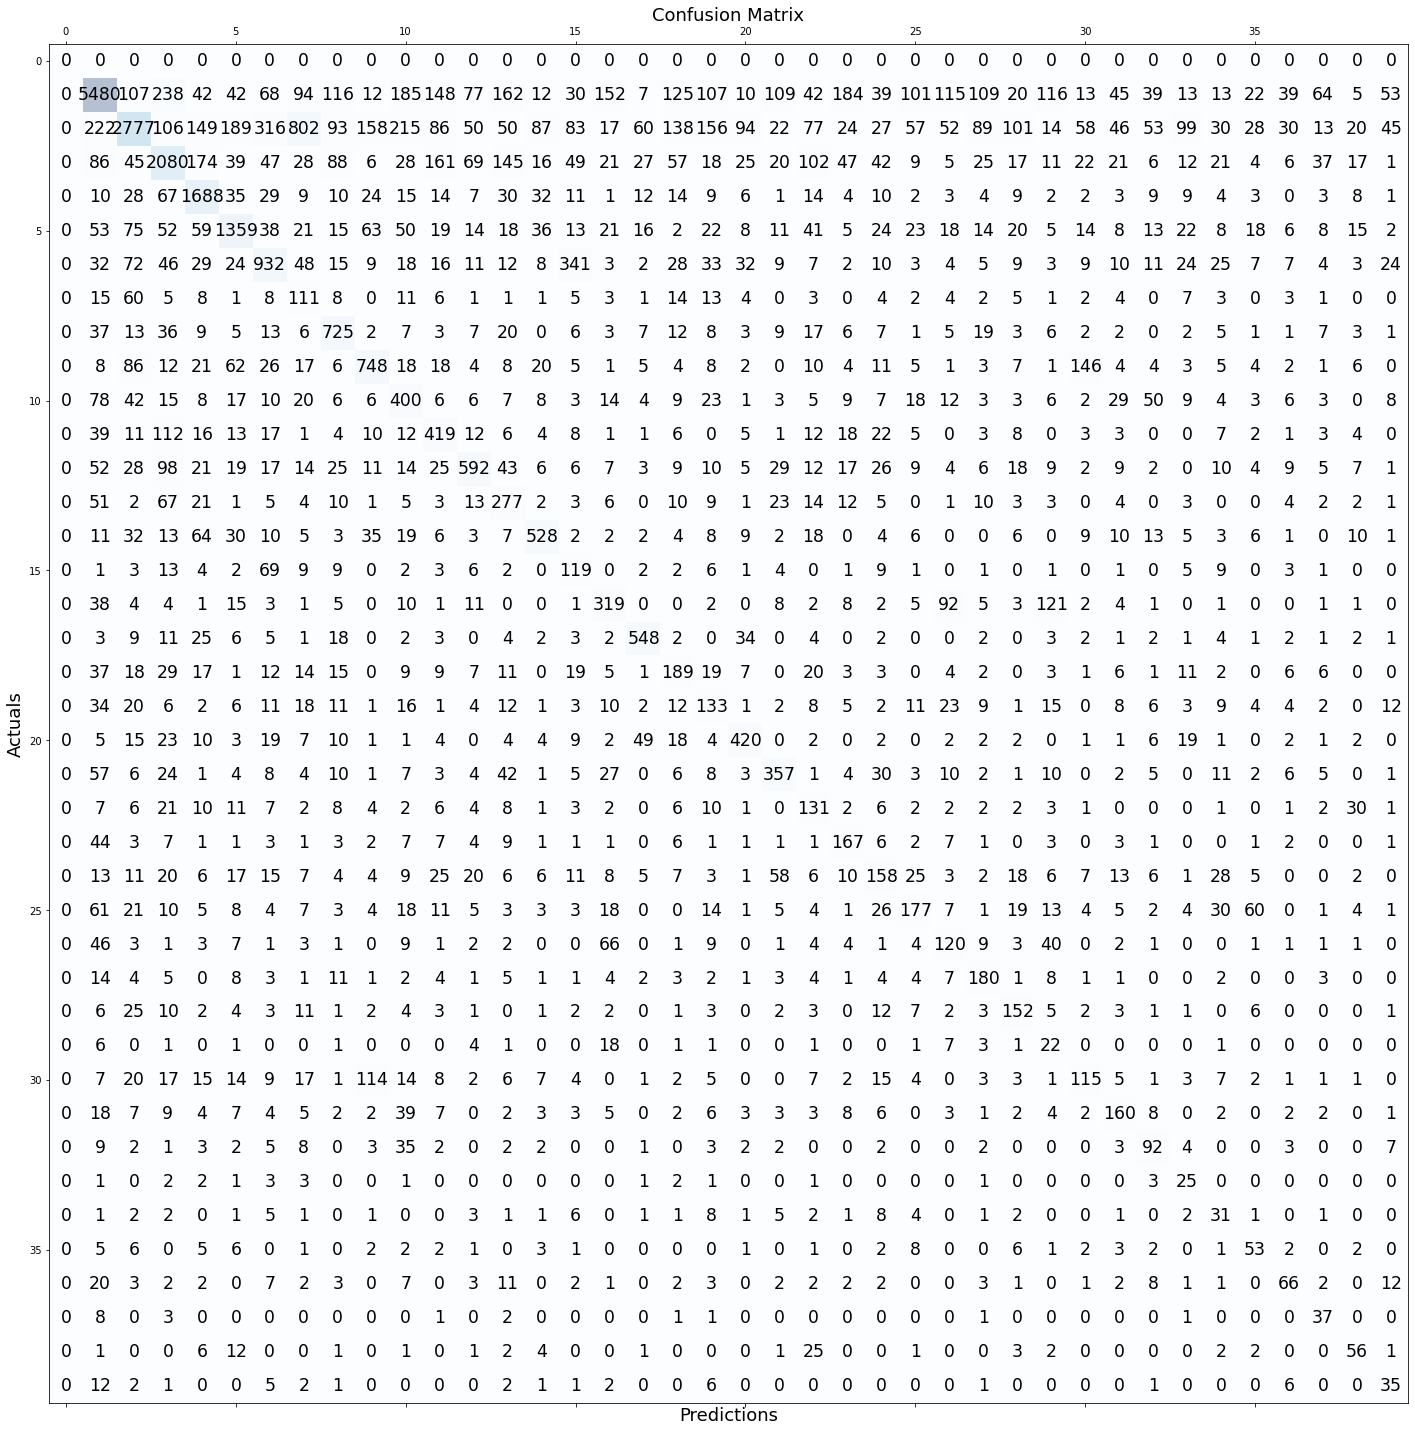

In [57]:
confusion_matrix = tf.math.confusion_matrix(classes, test_category_sequence).numpy()

fig, ax = plt.subplots(figsize=(25, 25))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.savefig('full_confusion.png')
plt.show()


In [46]:
#repeat the above process with only the top 6 classes

limited_df = df.query('category == "POLITICS" or category == "WELLNESS" or category == "ENTERTAINMENT" or category == "TRAVEL" or category == "STYLE" or category == "PARENTING"')
limited_df['category'] = limited_df['category'].str.split(' ').str[0]

In [47]:
limited_train, limited_test = train_test_split(limited_df, test_size=0.2)
limited_train_headlines = limited_train['headline'].to_numpy()
limited_train_categories = limited_train['category'].to_numpy()
limited_test_headlines = limited_test['headline'].to_numpy()
limited_test_categories = limited_test['category'].to_numpy()

In [59]:
limited_category_tokenizer = Tokenizer()
limited_category_tokenizer.fit_on_texts(df['category'])

limited_train_category_sequence = np.array([entry[0] for entry in limited_category_tokenizer.texts_to_sequences(limited_train_categories)])
limited_test_category_sequence = np.array([entry[0] for entry in limited_category_tokenizer.texts_to_sequences(limited_test_categories)])

{'politics': 1, 'wellness': 2, 'entertainment': 3, 'style': 4, 'travel': 5, 'parenting': 6, 'healthy': 7, 'queer': 8, 'food': 9, 'business': 10, 'comedy': 11, 'sports': 12, 'black': 13, 'home': 14, 'parents': 15, 'the': 16, 'weddings': 17, 'women': 18, 'impact': 19, 'divorce': 20, 'crime': 21, 'arts': 22, 'media': 23, 'weird': 24, 'green': 25, 'worldpost': 26, 'religion': 27, 'science': 28, 'world': 29, 'taste': 30, 'tech': 31, 'money': 32, 'fifty': 33, 'good': 34, 'environment': 35, 'college': 36, 'latino': 37, 'culture': 38, 'education': 39}


In [49]:
vectorize_layer.adapt(limited_train_headlines)

In [50]:
limited_model = Sequential([
    vectorize_layer, 
    Embedding(VOCAB_SIZE, EMBED_DIMS), 
    Conv1D(kernel_size = CONV_KERNEL, filters = CONV_FILTERS, input_shape = (HEADLINE_TRUNC_LENGTH, EMBED_DIMS)), 
    LeakyReLU(alpha = .2),
    MaxPooling1D(), 
    Flatten(),
    Dense(7, activation = 'softmax')])

In [51]:
limited_model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [52]:
limited_fit = limited_model.fit(limited_train_headlines, limited_train_category_sequence,
    validation_data=(limited_test_headlines, limited_test_category_sequence),
    batch_size = 32,
    epochs=2)

Epoch 1/2
2428/2428 [==============================] - 32s 12ms/step - loss: 0.9760 - accuracy: 0.6403 - val_loss: 0.5257 - val_accuracy: 0.8247
Epoch 2/2
2428/2428 [==============================] - 31s 13ms/step - loss: 0.4454 - accuracy: 0.8516 - val_loss: 0.5109 - val_accuracy: 0.8290


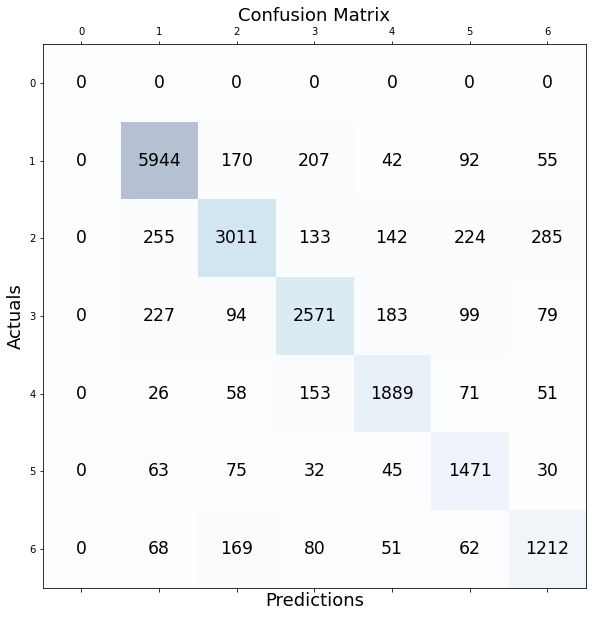

In [56]:
limited_classes = [int(tf.argmax(entry)) for entry in limited_model.predict(limited_test_headlines)]
limited_confusion_matrix = tf.math.confusion_matrix(limited_classes, limited_test_category_sequence).numpy()

figl, axl = plt.subplots(figsize=(10, 10))
axl.matshow(limited_confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(limited_confusion_matrix.shape[0]):
    for j in range(limited_confusion_matrix.shape[1]):
        axl.text(x=j, y=i,s=limited_confusion_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.savefig('limited_confusion.png')
plt.show()

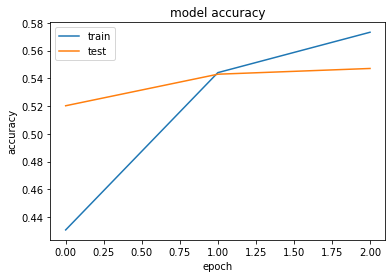

In [54]:
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('full_accuracy_vs_epoch.png')
plt.show()


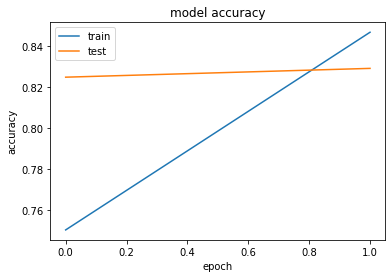

In [55]:
plt.plot(limited_fit.history['accuracy'])
plt.plot(limited_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('limited_accuracy_vs_epoch.png')
plt.show()
